In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.patches as patches
import torch
import copy
import sys
sys.path.append("/Users/LOCCO_Louise/Documents/Git/code_amaury")
from simu_PSF_polarMFM import *
from extract_experimental_psf import *
from tqdm import tqdm
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:   
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [3]:
d = np.array([1.1643099, 1.4462458, 1.7931267])
d = np.array([np.mean(d)-0.350, np.mean(d), np.mean(d)+0.350])
QE = 0.92
EM = 250
sensitivity = 15.4

In [4]:
Nframe=15

In [5]:
raw = np.zeros((Nframe,6,214,129))

In [6]:
path_info = '\\\\NAS_LOCCO\\Amaury\\DATA\\PolMFM_SilicaBeads_SLB_NR\\image_Pos0_2.ome_results_fr1to8095_method=Propagation matrix_box-method=Fixed_invertRotationPolarizer_corr.csv'

In [7]:
def extract_frames(frame_0, N_frame):
    error_indices = []
    for i in range(N_frame):
        number = str(frame_0 + i).zfill(4)
        print(number)
        path_data = '\\\\NAS_LOCCO\\Amaury\\DATA\\PolMFM_SilicaBeads_SLB_NR\\2024-01-11_SilicaBeads_Lipids_NR\\001_SM_560nm_EM250_25ms\\SilicaBead\\images\\RAW_DATA\\image_Pos0_2_reco\\image_Pos0_2_'+number+'.tif'
        raw_ = extract_raw(path_data)
        if raw_ is None:
            error_indices.append(i)
            continue
        else:
            raw[i] = raw_
        del(raw_)
    return raw, error_indices

def extract_positions(frame_0, N_frame, error_indices):
    index_frame = []
    x, y, z, rho, delta = [], [], [], [], []
    ind = 0
    for i in range(N_frame):
        if i not in error_indices:
            x__, y__, z__, rho__, delta__ = position_from_data(data, frame_0+i)
            x = np.concatenate((x, x__))
            y = np.concatenate((y, y__))
            z = np.concatenate((z, z__))
            rho = np.concatenate((rho, rho__))
            delta = np.concatenate((delta, delta__))
            for k in range(len(x__)):
                index_frame.append(ind)
        ind+=1
    index_frame=np.array(index_frame)
    return x, y, z, rho, delta, index_frame

def limit(x, lim, slope, upper=True):
    '''
    if upper:
       return torch.sum(torch.tensor(1/(1+torch.exp(-slope*(x-lim))), requires_grad=True, device=device))
    else:
        return torch.sum(torch.tensor(1/(1+torch.exp(slope*(x-lim))), requires_grad=True, device=device))
    '''
    if upper:
        return torch.sum(torch.exp((x-lim)*slope))
    else:
        return torch.sum(torch.exp(-1*(x-lim)*slope))
    
def loss_pos(xp, yp, zp, rho, eta, delta, N_photons, data, second_plane, background, sigma, dim_simu):
    u, v, M_ = compute_M(xp=xp, yp=yp, zp=zp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, aberrations=False)
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    x_bound = limit(xp, 5*0.12, 100, upper=True) + limit(xp, -5*0.12, 100, upper=False)
    y_bound = limit(yp, 5*0.12, 100, upper=True) + limit(yp, -5*0.12, 100, upper=False)
    z_bound = limit(zp, 5., 100, upper=True) + limit(zp, 0, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss +x_bound+y_bound+z_bound#+N_bound

def loss_angle(M_, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]

    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss + 1000.*(delta_bound)# + N_bound) #+ 100000*torch.sum(h**2)

def loss_angle_with_M(polar_proj, polar_proj2, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    u, v, M_ = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=polar_proj, polar_offset2=polar_proj2)
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    
    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss + 1000.*(delta_bound)# + N_bound) #+ 100000*torch.sum(h**2)

def score_eval(M_, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    score = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)), dim=(1,2,3,4))
    return score.numpy() 

In [8]:
data = pos_from_csv(path_info)

In [9]:
N_batch = 350 

0001
0002
0003
0004
0005
0006
0007
0008
0009
0010


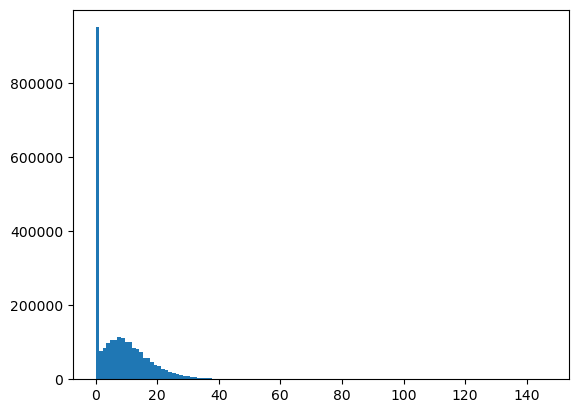

In [10]:
def noise_analytical(value, b1, s1, b2, s2):
    num_points=2000
    t = torch.linspace(0, 1, num_points).unsqueeze(0)  # shape: (1, 100)
    cst = torch.tensor([1. for fgh in range(num_points)])
    
    r_range = (value.unsqueeze(1) * t)
    l_range = (5*value.unsqueeze(1) * t)
    dr_range = ((value/num_points).unsqueeze(1) * cst)
    dl_range = ((5*value/num_points).unsqueeze(1) * cst)
    
    rr = r_range.unsqueeze(2).expand(-1, num_points, num_points)
    ll = l_range.unsqueeze(1).expand(-1, num_points, num_points)
    dr = dr_range.unsqueeze(2).expand(-1, num_points, num_points)
    dl = dl_range.unsqueeze(1).expand(-1, num_points, num_points)    

    return (1/(2*torch.pi*s1*s2))*torch.sum(((ll**(value.view(-1, 1, 1)-rr))/(torch.exp(torch.lgamma(1+value.view(-1, 1, 1)-rr))))*dr*dl*torch.exp(-ll -0.5*((ll-b1)/s1)**2 -0.5*((rr-b2)/s2)**2), dim=(1,2))

def distrib_approx(data):
    NN = len(data)
    histo = plt.hist(data, bins=int(NN/20000))
    plt.show()
    dhisto = histo[1][1]-histo[1][0]
    x = histo[1]+dhisto/2
    y = histo[0]
    y = y/np.sum(y)
    uu = y/dhisto
    del(histo)
    return x[:-1], uu

raw, error_indices = extract_frames(1, 10)
x, y, z, rho, delta, index_frame = extract_positions(1, 10, error_indices)
raw = raw*sensitivity/(QE*EM)

abscisse, distrib_exp = distrib_approx(raw.flatten())
absc = torch.tensor(abscisse)
res = noise_analytical(absc, 10.5, 6.8, 11, 1.)
del(abscisse, distrib_exp)

In [ ]:
batch_offset = 0

In [ ]:
offset_count = 14.1
print(offset_count)

In [ ]:
for batch_number in range(N_batch):
    t0 = time.time()
    raw, error_indices = extract_frames((batch_number+batch_offset)*Nframe+1, Nframe)
    x, y, z, rho, delta, index_frame = extract_positions((batch_number+batch_offset)*Nframe+1, Nframe, error_indices)
    raw = raw*sensitivity/(QE*EM)

    sigma = np.std(raw.flatten())
    background = np.mean(raw.flatten())

    nb = len(x)
    for k, ele in enumerate(x):
        if np.isnan(x[nb-1-k]) or np.isnan(y[nb-1-k]) or np.isnan(z[nb-1-k]) or np.isnan(rho[nb-1-k]) or np.isnan(delta[nb-1-k]):
            x = np.delete(x,nb-1-k,0)
            y = np.delete(y,nb-1-k,0)
            z = np.delete(z,nb-1-k,0)
            rho = np.delete(rho,nb-1-k,0)
            delta = np.delete(delta,nb-1-k,0)
            index_frame = np.delete(index_frame,nb-1-k,0)
    
    NPSF = len(x)

    single_psf = extract_raw_xy(raw[0], x[index_frame==0], y[index_frame==0])
    for i in range(1,Nframe):
        single_psf = np.concatenate((single_psf, extract_raw_xy(raw[i], x[index_frame==i], y[index_frame==i])))

    single_psf = single_psf[:,::-1]

    x_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)
    y_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)

    z_exp =  torch.tensor([1.2 for k in range(len(x))], requires_grad=False, device=device) 

    rho_exp = torch.tensor(rho, requires_grad=False, device=device)
    delta_exp = torch.tensor(delta, requires_grad=False, device=device)

    d_ = -torch.tensor([d[1] for k in range(len(x))], requires_grad=False, device=device)
    second_plane = torch.tensor([d[1]-d[0], 0, d[1]-d[2]])
    polar_projections = torch.tensor(np.array([0, 45, 0]))

    N=torch.tensor(80, device=device)
    l_pixel=torch.tensor(16, device=device)
    NA=torch.tensor(1.4, device=device)
    mag=torch.tensor(100, device=device)
    lambd=torch.tensor(638, device=device)
    f_tube=torch.tensor(200, device=device)
    MAG=torch.tensor(200/150, device=device)

    xx, yy, th1, phi, [Ex0, Ex1, Ex2], [Ey0, Ey1, Ey2], r, r_cut, k_, f_o = vectorial_BFP_perfect_focus(N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, device=device)

    noisy_psf = torch.tensor([single_psf[k] for k in range(len(x))], device=device)

    u, v, M = compute_M(xp=x_start, yp=y_start, zp=z_exp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)
    h = PSF(rho=torch.tensor(np.array([45. for k in range(NPSF)]), device=device), eta=torch.tensor([45. for k in range(NPSF)], device=device), delta=torch.tensor([100. for k in range(NPSF)], device=device), M=M, N_photons=torch.tensor([1000. for k in range(NPSF)], device=device))
    
    dim_simu = int(h.shape[-1]//2)

    ### first SGD on pos
    Nstart = torch.tensor([3000 for i in range(NPSF)], requires_grad=False, device=device)
    eta_rd = torch.tensor([45. for k in range(NPSF)], requires_grad=False, device=device)
    delta_rd = torch.tensor([150. for k in range(NPSF)], requires_grad=False, device=device)

    params = torch.cat((x_start, y_start, z_exp, Nstart/1000))
    params.requires_grad=True

    optimizer = torch.optim.Adam([params], lr=0.15)  # Learning rate = 0.012

    num_epochs_max = 100
    loss_ = []
    z__ = []
    for i in tqdm(range(num_epochs_max)):
        optimizer.zero_grad()  # Reset gradients
        loss = loss_pos(params[0:NPSF], params[NPSF:2*NPSF], params[2*NPSF:3*NPSF], rho_exp
                            , eta_rd, delta_exp, params[3*NPSF:4*NPSF]*1000, noisy_psf, second_plane, background, sigma, dim_simu) 
        loss_.append(loss.cpu().detach().numpy())
        z__.append(params[2*NPSF:3*NPSF].cpu().detach().numpy())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    ax = plt.plot(loss_)
    plt.ylim((np.min(np.array(loss_)), np.max(np.array(loss_))))
    plt.show()
    ax = plt.plot(z__)
    plt.show()
    del(ax, loss_)

    x_found = params[0:NPSF].detach()
    y_found = params[NPSF:2*NPSF].detach()
    z_found = params[2*NPSF:3*NPSF].detach()
    N_found = params[3*NPSF:4*NPSF].detach()*1000
    del(params, loss)
    print('NPSF = ', NPSF)

    ### SGD 2 on orientation

    u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)
    
    eta_rd = torch.tensor([90. for k in range(NPSF)], requires_grad=False, device=device)
    offset_proj=10.
    #params = torch.cat((rho_exp, eta_rd, delta_exp, N_found/1000))
    #params = torch.cat((eta_rd, eta_rd, eta_rd, N_found/1000))
    params = torch.cat((eta_rd, eta_rd, eta_rd, N_found/1000, torch.tensor([offset_proj, offset_proj], requires_grad=False, device=device)))
    params.requires_grad=True

    # Use Stochastic Gradient Descent (SGD) to optimize params
    optimizer = torch.optim.Adam([params], lr=0.7)  # Learning rate = 0.01

    num_epochs_max = 220
    loss_ = []
    eta_ = []
    pol=[]
    for i in tqdm(range(num_epochs_max)):
        optimizer.zero_grad()  # Reset gradients
        #loss = loss_angle(M.detach(), params[:NPSF], params[1*NPSF:2*NPSF], params[2*NPSF:3*NPSF], 1000*params[3*NPSF:4*NPSF], noisy_psf, background, sigma, dim_simu)
        loss = loss_angle_with_M(params[-1], params[-2], params[:NPSF], params[1*NPSF:2*NPSF], params[2*NPSF:3*NPSF], 1000*params[3*NPSF:4*NPSF], noisy_psf, background, sigma, dim_simu)
        loss_.append(loss.cpu().detach().numpy())
        eta_.append(params[1*NPSF:2*NPSF].cpu().detach().numpy())
        pol.append(params[-2:].cpu().detach().numpy())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    fig, ax = plt.subplots(2)
    ax[0].plot(loss_) 
    ax[0].set_ylim((np.min(np.array(loss_)), np.max(np.array(loss_))))
    ax[1].plot(pol)
    plt.show()
    del(fig, ax)

    rho_found=params[0:NPSF].detach()%180
    eta_found=params[1*NPSF:2*NPSF].detach()%180
    delta_found=params[2*NPSF:3*NPSF].detach()
    N_found2 = 1000*params[3*NPSF:4*NPSF].detach()
    offset_proj_found = params[-1].detach()
    offset_proj_found2 = params[-2].detach()
    del(params, loss, eta_, loss_)
    u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=offset_proj_found)
    score = score_eval(M.detach().cpu(), rho_found.cpu(), eta_found.cpu(), delta_found.cpu(), N_found2.cpu(), noisy_psf.cpu(), background, sigma, dim_simu)
    x_ = (x/0.120).astype(int)*0.12 + x_found.cpu().detach().numpy()
    y_ = (y/0.120).astype(int)*0.12 + y_found.cpu().detach().numpy()
    np.savez_compressed('D:/AMAURY/experimental_processed/stage/NAME/'+str(int(batch_number)+1+batch_offset)+'.npz', frame = index_frame, x=x_, y=y_, z=1000*z_found.cpu().detach().numpy(), N_photons=N_found2.cpu().detach().numpy(), offset_proj=offset_proj_found.cpu().detach().numpy(), offset_proj2=offset_proj_found2.cpu().detach().numpy(), rho=rho_found.cpu().detach().numpy(), eta=eta_found.cpu().detach().numpy(), delta=delta_found.cpu().detach().numpy(), score=score, x_start=x, y_start=y, z_start=z, rho_start=rho, delta_start=delta)
    
    if batch_number==0:
        best = np.argmin(score)
        dim_data = 6
        u, v, M_end = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                        , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                        , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=offset_proj_found)
        h = PSF(rho=rho_found, eta=eta_found, delta=delta_found, M=M_end, N_photons=N_found2)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
        for uuu in range(h.shape[0]):
            vmin = 0.
            vmax = np.max(noisy_psf.cpu().detach().numpy()[uuu])
            fig, ax = plt.subplots(2,3)
            for i in range(2):
                for j in range(3):
                    ax[i,j].set_aspect('equal')
                    im = ax[i,j].pcolormesh(noisy_psf.cpu().detach().numpy()[uuu,j,i], cmap='grey', vmin=vmin, vmax=vmax)
                    ax[i,j].set_title(str(np.sum(noisy_psf.cpu().detach().numpy()[uuu,j,i])))
            fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8)
            plt.show()
            del(fig, ax)
            vmin = 0.
            vmax = np.max(h.cpu().detach().numpy()[uuu])
            fig, ax = plt.subplots(2,3)
            for i in range(2):
                for j in range(3):
                    ax[i,j].set_aspect('equal')
                    im = ax[i,j].pcolormesh(h.cpu().detach().numpy()[uuu,j,i], cmap='grey', vmin=vmin, vmax=vmax)
                    ax[i,j].set_title(str(np.sum(h.cpu().detach().numpy()[uuu,j,i])))
            fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8)
            plt.show()
            del(fig, ax)
    